Found 8859 images belonging to 2 classes.
Found 2214 images belonging to 2 classes.
Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 103s 359ms/step - accuracy: 0.5597 - loss: 0.6955 - val_accuracy: 0.6870 - val_loss: 0.6020
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 165us/step - accuracy: 0.6562 - loss: 0.6200 - val_accuracy: 1.0000 - val_loss: 0.4179
Epoch 3/10


c:\Program Files\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


276/276 ━━━━━━━━━━━━━━━━━━━━ 100s 360ms/step - accuracy: 0.6547 - loss: 0.6089 - val_accuracy: 0.5983 - val_loss: 0.6599
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 107us/step - accuracy: 0.5938 - loss: 0.6529 - val_accuracy: 0.5000 - val_loss: 0.5117
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 101s 361ms/step - accuracy: 0.7038 - loss: 0.5557 - val_accuracy: 0.7640 - val_loss: 0.5026
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 103us/step - accuracy: 0.7500 - loss: 0.5773 - val_accuracy: 0.8333 - val_loss: 0.2797
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 100s 360ms/step - accuracy: 0.7321 - loss: 0.5252 - val_accuracy: 0.6775 - val_loss: 0.5647
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 103us/step - accuracy: 0.7500 - loss: 0.4220 - val_accuracy: 0.3333 - val_loss: 1.1645
Epoch 9/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 101s 363ms/step - accuracy: 0.7595 - loss: 0.4918 - val_accuracy: 0.7387 - val_loss: 0.4863
Epoch 10/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 83us/step - accuracy: 0.7812 - loss: 0.3993 - val

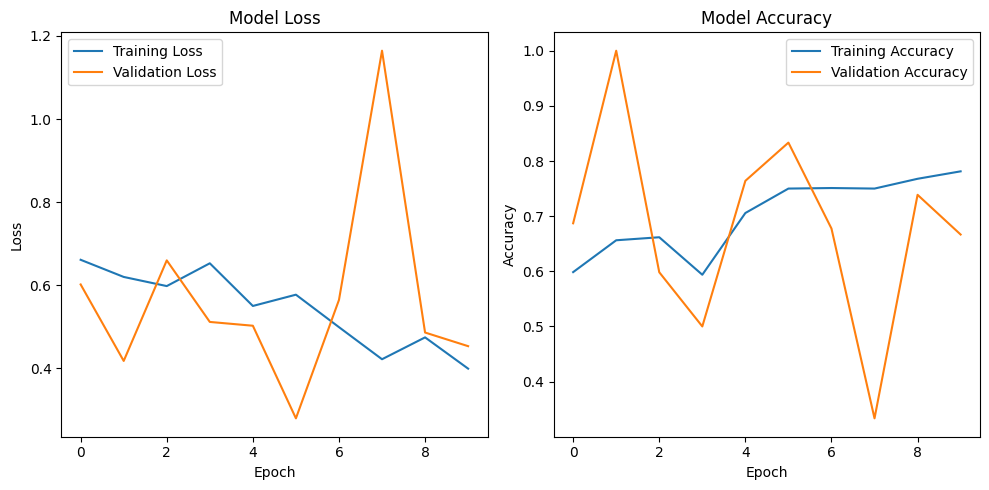

70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 189ms/step - accuracy: 0.7636 - loss: 0.4929
Validation Accuracy: 0.7610659599304199


In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout, GlobalAveragePooling2D, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Add, Dense, Dropout
import matplotlib.pyplot as plt

# CNN Block for feature extraction
def cnn_block(inputs):
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = GlobalAveragePooling2D()(x)
    return x

# Transformer Block
def transformer_block(inputs, num_heads=4, ff_dim=128, dropout=0.1):
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + inputs)
    
    # Feed Forward Network
    ffn_output = Dense(ff_dim, activation='relu')(attention_output)
    ffn_output = Dropout(dropout)(ffn_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output + attention_output)
    
    return ffn_output

# Full Hybrid Model
def create_hybrid_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # CNN Block
    cnn_output = cnn_block(inputs)
    
    # Transformer Block: reshape the output to add the temporal dimension
    transformer_input = Reshape((1, cnn_output.shape[-1]))(cnn_output)
    transformer_output = transformer_block(transformer_input)
    
    # Squeeze to remove the temporal dimension and return to the normal tensor shape
    transformer_output = Reshape((transformer_output.shape[-1],))(transformer_output)
    
    # Fully Connected Layer for Classification
    x = Dense(128, activation='relu')(transformer_output)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification: violence (1) or non-violence (0)
    
    model = Model(inputs, outputs)
    return model

# Compile the model
def compile_hybrid_model(model):
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Main function to execute workflow
def main():
    dataset_path = r'C:\Users\abhishik chebrolu\Downloads\AINN pro\archive\new_violence'  # Path to your dataset with violence and non-violence frames
    input_shape = (224, 224, 3)
    
    # Create and compile the hybrid model
    hybrid_model = create_hybrid_model(input_shape)
    compile_hybrid_model(hybrid_model)
    
    # Use ImageDataGenerator for data loading and augmentation
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        validation_split=0.2  # Automatically split 20% for validation
    )
    
    batch_size = 32
    
    # Train and validation data generators
    train_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary',  # Binary classification (violence or non-violence)
        subset='training'
    )
    
    val_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary',  # Binary classification (violence or non-violence)
        subset='validation'
    )
    
    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the hybrid model
    history = hybrid_model.fit(
        train_generator,
        validation_data=val_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_steps=val_generator.samples // batch_size,
        epochs=10,
        callbacks=[early_stopping]
    )
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Evaluate on validation data
    val_loss, val_accuracy = hybrid_model.evaluate(val_generator)
    print(f"Validation Accuracy: {val_accuracy}")

if __name__ == "__main__":
    main()


Found 8859 images belonging to 2 classes.
Found 2214 images belonging to 2 classes.
Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 634s 2s/step - accuracy: 0.7155 - loss: 0.5511 - val_accuracy: 0.8691 - val_loss: 0.3168 - learning_rate: 1.0000e-04
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9375 - loss: 0.2003 - val_accuracy: 1.0000 - val_loss: 0.1687 - learning_rate: 1.0000e-04
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 1290s 5s/step - accuracy: 0.8930 - loss: 0.2531 - val_accuracy: 0.8505 - val_loss: 0.3533 - learning_rate: 1.0000e-04
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9375 - loss: 0.1654 - val_accuracy: 0.8333 - val_loss: 0.4537 - learning_rate: 1.0000e-04
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 580s 2s/step - accuracy: 0.9262 - loss: 0.1837 - val_accuracy: 0.8877 - val_loss: 0.2886 - learning_rate: 1.0000e-04
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9375 - loss: 0.1805 - val_accuracy: 0.8333 - val_loss: 0.3482 - le

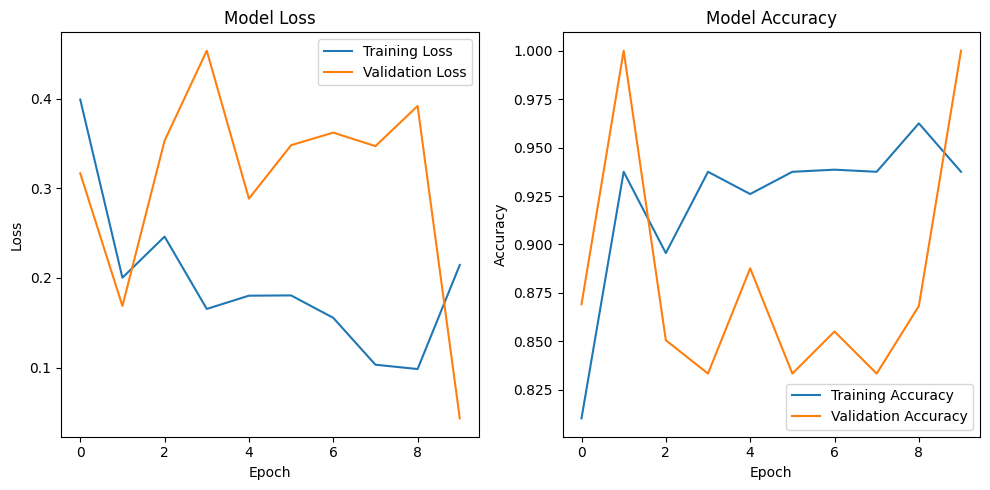

In [8]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Dense, GlobalAveragePooling2D, Dropout, LayerNormalization, MultiHeadAttention, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt

# Create Transfer Learning Autoencoder (VGG16 as Encoder)
def create_transfer_learning_autoencoder(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Unfreeze some layers for fine-tuning
    for layer in base_model.layers[:-4]:  # Fine-tune the last 4 layers
        layer.trainable = False
    
    # CNN block output
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Pooling for spatial reduction
    cnn_output = Dense(256, activation='relu')(x)  # Additional dense layer

    return base_model.input, cnn_output

# Transformer block
def transformer_block(inputs, num_heads=4, ff_dim=256):
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + inputs)
    
    ffn_output = Dense(ff_dim, activation='relu')(attention_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    
    transformer_output = LayerNormalization(epsilon=1e-6)(ffn_output + attention_output)
    return transformer_output

# Hybrid CNN-Transformer Model
def create_hybrid_model(input_shape):
    # CNN Block (VGG16-based)
    cnn_input, cnn_output = create_transfer_learning_autoencoder(input_shape)

    # Reshape CNN output to add a sequence dimension (needed for the transformer)
    cnn_output_reshaped = Reshape((1, -1))(cnn_output)

    # Transformer Block
    transformer_output = transformer_block(cnn_output_reshaped)
    transformer_output_flat = Reshape((-1,))(transformer_output)  # Flatten the transformer output

    # Output layer
    outputs = Dense(1, activation='sigmoid')(transformer_output_flat)

    # Full hybrid model
    model = Model(cnn_input, outputs)
    return model

# Compile the model
def compile_hybrid_model(model):
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Main function to execute workflow
def main():
    dataset_path = r'C:\Users\abhishik chebrolu\Downloads\AINN pro\archive\new_violence'  # Path to dataset
    input_shape = (224, 224, 3)

    # Create and compile the hybrid model
    hybrid_model = create_hybrid_model(input_shape)
    compile_hybrid_model(hybrid_model)

    # Use ImageDataGenerator for data loading and augmentation
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        zoom_range=0.3,
        validation_split=0.2  # Automatically split 20% for validation
    )

    batch_size = 32

    # Train and validation data generators
    train_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary',  # For binary classification
        subset='training'
    )
    
    val_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary',  # For binary classification
        subset='validation'
    )

    # Callbacks for early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

    # Train the hybrid model
    history = hybrid_model.fit(
        train_generator,
        validation_data=val_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_steps=val_generator.samples // batch_size,
        epochs=10,
        callbacks=[early_stopping, lr_scheduler]
    )

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Found 8859 images belonging to 2 classes.
Found 2214 images belonging to 2 classes.
Found 11073 images belonging to 2 classes.
Epoch 1/10


C:\Users\abhishik chebrolu\AppData\Roaming\Python\Python312\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\abhishik chebrolu\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


276/276 ━━━━━━━━━━━━━━━━━━━━ 719s 3s/step - accuracy: 0.7318 - loss: 0.5134 - val_accuracy: 0.8578 - val_loss: 0.3371 - learning_rate: 1.0000e-04
Epoch 2/10
  1/276 ━━━━━━━━━━━━━━━━━━━━ 10:07 2s/step - accuracy: 0.8125 - loss: 0.3636

c:\Program Files\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8125 - loss: 0.3636 - val_accuracy: 0.8333 - val_loss: 0.3440 - learning_rate: 1.0000e-04
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 775s 3s/step - accuracy: 0.8943 - loss: 0.2479 - val_accuracy: 0.8764 - val_loss: 0.3133 - learning_rate: 1.0000e-04
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8438 - loss: 0.2875 - val_accuracy: 1.0000 - val_loss: 0.1029 - learning_rate: 1.0000e-04
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 811s 3s/step - accuracy: 0.9185 - loss: 0.1965 - val_accuracy: 0.8850 - val_loss: 0.3134 - learning_rate: 1.0000e-04
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9375 - loss: 0.1448 - val_accuracy: 1.0000 - val_loss: 0.0038 - learning_rate: 1.0000e-04
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 594s 2s/step - accuracy: 0.9462 - loss: 0.1468 - val_accuracy: 0.8872 - val_loss: 0.3828 - learning_rate: 1.0000e-04
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9688 -

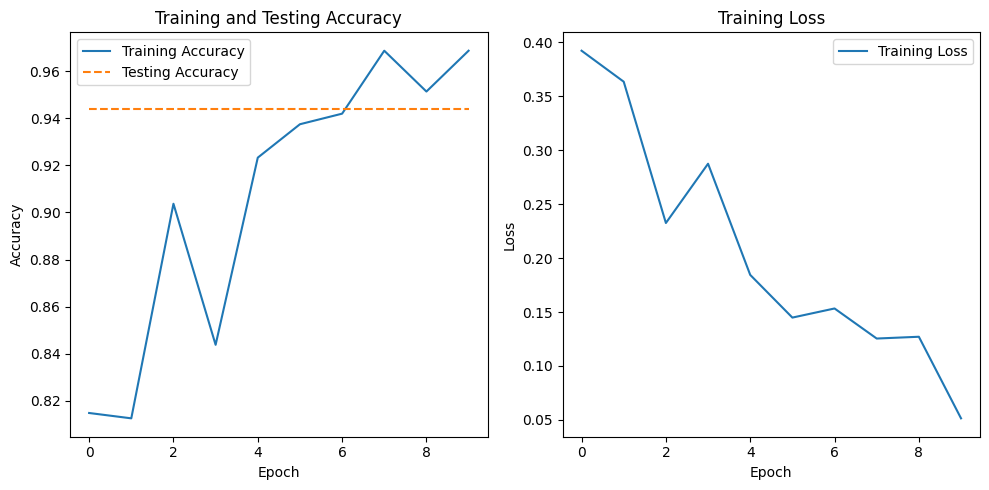

In [9]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Dense, GlobalAveragePooling2D, Dropout, LayerNormalization, MultiHeadAttention, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Create Transfer Learning Autoencoder (VGG16 as Encoder)
def create_transfer_learning_autoencoder(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Unfreeze some layers for fine-tuning
    for layer in base_model.layers[:-4]:  # Fine-tune the last 4 layers
        layer.trainable = False
    
    # CNN block output
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Pooling for spatial reduction
    cnn_output = Dense(256, activation='relu')(x)  # Additional dense layer

    return base_model.input, cnn_output

# Transformer block
def transformer_block(inputs, num_heads=4, ff_dim=256):
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + inputs)
    
    ffn_output = Dense(ff_dim, activation='relu')(attention_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    
    transformer_output = LayerNormalization(epsilon=1e-6)(ffn_output + attention_output)
    return transformer_output

# Hybrid CNN-Transformer Model
def create_hybrid_model(input_shape):
    # CNN Block (VGG16-based)
    cnn_input, cnn_output = create_transfer_learning_autoencoder(input_shape)

    # Reshape CNN output to add a sequence dimension (needed for the transformer)
    cnn_output_reshaped = Reshape((1, -1))(cnn_output)

    # Transformer Block
    transformer_output = transformer_block(cnn_output_reshaped)
    transformer_output_flat = Reshape((-1,))(transformer_output)  # Flatten the transformer output

    # Output layer
    outputs = Dense(1, activation='sigmoid')(transformer_output_flat)

    # Full hybrid model
    model = Model(cnn_input, outputs)
    return model

# Compile the model
def compile_hybrid_model(model):
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Main function to execute workflow
def main():
    dataset_path = r'C:\Users\abhishik chebrolu\Downloads\AINN pro\archive\new_violence'  # Path to dataset
    input_shape = (224, 224, 3)

    # Create and compile the hybrid model
    hybrid_model = create_hybrid_model(input_shape)
    compile_hybrid_model(hybrid_model)

    # Use ImageDataGenerator for data loading and augmentation
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        zoom_range=0.3,
        validation_split=0.2  # Automatically split 20% for validation
    )

    batch_size = 32

    # Split dataset into train and validation sets
    train_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary',
        subset='training'
    )
    
    val_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'
    )

    # Split the dataset for testing using test generator
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        dataset_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary'
    )

    # Callbacks for early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

    # Train the hybrid model
    history = hybrid_model.fit(
        train_generator,
        validation_data=val_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_steps=val_generator.samples // batch_size,
        epochs=10,
        callbacks=[early_stopping, lr_scheduler]
    )

    # Testing accuracy
    test_loss, test_accuracy = hybrid_model.evaluate(test_generator)
    print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

    # Plot training and testing accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot([test_accuracy] * len(history.history['accuracy']), label='Testing Accuracy', linestyle='--')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
